In [2]:
import time

import matplotlib.pyplot as plt
import pandas as pd
from nltk.corpus import stopwords
from nltk import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import pickle
import nltk
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('averaged_perceptron_tagger')
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\flavi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\flavi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\flavi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\flavi\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\flavi\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


# Hypothesis H1 analysis
#### This notebook is dedicated to the exploration of the Hypotesis H1
This hypothesis has an explorative nature. The main goal is to find out if there exists topics discussed in the reviews by aribnb users that are valued higly by users.
To do so we first build a LDA model that is able to extract topics discussed in reviews in an unsupervised way. This was done in a previous script.
Reviews are splitted in phrases and for each phrase the greatest topic probability is chosen as a topic score and with sentiment analyisis we give a sentiment score to each phrase. More detail later. The various phrases in a review are combined in a review topic-sentiment matrix. We have tried to predict in which price category an airbnb falls in to using this matrixes to build a predictor.

## Producing the review_topic_sentiment matirx
#### As a first thing i copy the methods used to clean and tokenize the reviews. This is done to simulate the ingestion of new reviews.

In [3]:
# preprocessing function

def preprocess(text):
    with open(r'C:\Users\flavi\PycharmProjects\lda_test\processed_data\host_names.pkl', 'rb') as name_file:
        host_names = pickle.load(name_file)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word.isalpha()]
    tokens = ['host' if word in host_names else word for word in tokens]
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token.lower() not in stop_words]
    return ' '.join(tokens)

def get_topic(topic_distribution):
    return topic_distribution.argmax()


# loading the chosen LDA model
lda = r'C:\Users\flavi\PycharmProjects\lda_test\ldaS\lda_8_Mdf90_mdf10_100EPOCHS.pkl'
print('Loading lda...')
with open(lda, 'rb') as lda_file:
    LDA = pickle.load(lda_file)

# creating the vectorizer 
vectorizer_file = r'C:\Users\flavi\PycharmProjects\lda_test\ldaS\vectorizer_8_Mdf_90_10_100EPOCHS.pkl'
print('Loading vectorizer...')
vectorizer = pickle.load(open(vectorizer_file, 'rb'))
 
#vectorizer = CountVectorizer(max_df=0.90, min_df=10, stop_words='english')

# loading the vader sentiment analizer

sia = SentimentIntensityAnalyzer()

Loading lda...
Loading vectorizer...


#### Here are the strategies used to translate each review in to a matrix
1) This first strategy computes as a topic score the probability that a review talks about a given topic. then the review gets splitted in to phrases and once each phrase gets its chosen topic, a sentiment score is applied to it. Now we average the sentiment score per phrase topic and the result of this gets saved as the second column

In [4]:
sample_rev = """Our stay with Daniel was truly one of the highlights of mine and my partner's whirlwind European tour. Not only was the room smashingly decorated (a great example of modern Dutch living), spotlessly clean and serenely comfortable {think Zen), but having Daniel as a point of reference was our key to discovering the city. From the get-go he freely offered advice whenever we had questions about where to go or what to do in Amsterdam. 

The room is located at quite a distance from the heart of the city, but we didn't find this hindering. We were able to get to the center in a snap with the two bikes Daniel has available for a minimal charge or via any of the train or bus stops located within a stones throw of his front door. There are plenty of restaurants, cafes and groceries in the area. And staying here is also a great way to see how the locals are living.

I would recommend Daniel's residence to anyone looking for a smart, affordable alternative to hotels or hostels. As a gay couple especially we found him extremely welcoming. 

P.S. You can check my YouTube page for videos of our stay in Amsterdam, which includes a peek into the room: (Website hidden by Airbnb)"""


def get_topic(topic_distribution):
    return topic_distribution.argmax()

def review_to_matrix_1(text, LDA, vectorizer, sia):
    
    processed_text = [preprocess(text)]
    vect_rev = vectorizer.transform(processed_text)
    rev_topic_scores = LDA.transform(vect_rev)
    n_of_topics = len(rev_topic_scores[0])
    document_matrix = np.zeros((2, n_of_topics))
    sentences = nltk.sent_tokenize(text=text, language='english')
    max_topic_scores = np.zeros(n_of_topics)
    topic_frequency = np.ones(n_of_topics)
    topic_sentiment_accumulator = np.zeros(n_of_topics)
    for sentence in sentences:
        processed_sentence = [preprocess(sentence)]
        sentence_topic_scores = LDA.transform(vectorizer.transform(processed_sentence))
        topic = get_topic(sentence_topic_scores)
        topic_frequency[topic] += 1
        #('Current sentence:',sentence)
        #print('Topic sentence:', topic)
       # print(sentence_topic_scores[0][topic])
        if sentence_topic_scores[0][topic] > max_topic_scores[topic]:
            max_topic_scores[topic] = sentence_topic_scores[0][topic]
        sentiment = sia.polarity_scores(sentence).get('compound')
        topic_sentiment_accumulator[topic] += sentiment
        #print('Compound sentiment:', sentiment)
    document_matrix[0,:] = max_topic_scores
    document_matrix[1,:] = topic_sentiment_accumulator/topic_frequency

    return document_matrix
    

    
test_rev1_df = pd.DataFrame(review_to_matrix_1(LDA=LDA, vectorizer=vectorizer,text= sample_rev, sia=sia))
print(test_rev1_df)

       0         1    2         3         4         5         6         7
0  0.125  0.510183  0.0  0.902688  0.854133  0.700418  0.495911  0.853895
1  0.000  0.212300  0.0  0.293600 -0.051033  0.000000  0.389467  0.312450


We migth need to tune vader for our specific use case. If the classifier for the prices 

In [ ]:
# Connection to mongoDb
from pymongo import MongoClient
# Connettersi al client MongoDB
client = MongoClient('mongodb://localhost:27017/')
db = client['dsbda_project']
collection = db['row']

# RESTRIZIONE APPLICATA AI DATI, per gestire volume
data_inizio = "2009-01-01"
data_fine = "2018-12-31"

# Query per selezionare i campi specificati
query = {
    "date": {
        "$gte": data_inizio,
        "$lte": data_fine
    }
}

# Seleziona i campi desiderati
projection = {
    "_id": 0,  # Escludi il campo _id
    "listing_id": 1,
    "price" : 1,
    "name" : 1,
    "host_name" : 1,
    "host_id" : 1,
    "longitude": 1,
    "latitude": 1,
    "date": 1,
    "comment": 1
}

cursor = collection.find(query, projection)
data = list(cursor)
df_reviews_full = pd.DataFrame(data)

print(df_reviews_full.head())

## Classifying the reviews
The next step is to classify the reviews for all the documents and for each lising to compute the average review matrix

In [5]:
import csv
# The first thing is to load the dataframe and check if it is correctly loaded.
csv_file_path= r'C:\Users\flavi\PycharmProjects\lda_test\processed_data\dataset.csv'
df_reviews_full = pd.read_csv(csv_file_path, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
df_reviews_full = df_reviews_full.dropna()
df_reviews_full = df_reviews_full.sort_values(by='id')
df_reviews_full = df_reviews_full.sample(frac=0.3).reset_index(drop = True) # not a good implementation, maybe changhe it
print(df_reviews_full.head(50))

    Unnamed: 0        id                                               name  \
0        41010    846281                     Stylish studio in canal house    
1       118010   4248769      Citycentre, Canal-house, 5 Star, Room+Ensuite   
2        82918   2206038                      Lovely 4p apartment in Center   
3         8630    118117           Lovely self contained studio in Oud West   
4       128933   4892972                   Stylish, super central apartment   
5        80267   2080040             Centrally located apt. near Vondelpark   
6       258741  15814593  Modern apt, direct line to popular sights, che...   
7       218681  12549908                Luxury family home Amsterdam Oud-Zu   
8          870     28658                Cosy guest room near city centre -1   
9       330808  25220875   Spacious and Cosy flat in the heart of Amsterdam   
10      170912   7814872                       Little House Near the Amstel   
11       75064   1863202                         Von

In [6]:
# imports to have a progress bar displayed
from tqdm import tqdm
from tqdm.auto import tqdm

In [7]:
# The dataset is sorted on id now we add a column with the review matrix 
# Now we translate each review in a review matrix
print(len(df_reviews_full))
print('Processing reviews...')

tqdm.pandas()

df_reviews_full['rev_matrix'] = df_reviews_full['comments'].progress_apply(review_to_matrix_1,args=(LDA, vectorizer, sia))
print(df_reviews_full['rev_matrix'])

102043
Processing reviews...


  0%|          | 0/102043 [00:00<?, ?it/s]

0         [[0.0, 0.0, 0.781112152437849, 0.9124018103622...
1         [[0.0, 0.8904492751602125, 0.8540025145138379,...
2         [[0.0, 0.0, 0.7080558820992712, 0.488841056583...
3         [[0.8540614189967389, 0.0, 0.0, 0.0, 0.0, 0.90...
4         [[0.0, 0.0, 0.854067618073787, 0.0, 0.93747997...
                                ...                        
102038    [[0.0, 0.9027090162476086, 0.7809435923636496,...
102039    [[0.0, 0.8904727240951846, 0.8539974798898768,...
102040    [[0.0, 0.0, 0.7081126294603026, 0.0, 0.0, 0.0,...
102041    [[0.0, 0.0, 0.4490542194471466, 0.596389344014...
102042    [[0.781130677356257, 0.0, 0.7080558820992712, ...
Name: rev_matrix, Length: 102043, dtype: object


In [1]:
#save the output csv
df_reviews_full.to_csv(r'C:\Users\flavi\PycharmProjects\lda_test\processed_data\dataset_with_rev_matrix.csv')

NameError: name 'df_reviews_full' is not defined

In [8]:
# Now we compute the average for each airbnb and save the result in a new dataframe
tqdm.pandas()
def calculate_avg_rev_matrix(x):
    return np.mean(np.array(x.tolist()), axis=0)

df_avg_reviews = df_reviews_full.groupby('id')['rev_matrix'].progress_apply(calculate_avg_rev_matrix)
#print(df_avg_reviews.head(20))

df_avg_reviews = df_reviews_full.merge(df_avg_reviews, on='id',suffixes=('','_avg'))

#print(df_avg_reviews.head(20))

df_avg_reviews['price'] = df_avg_reviews['price'].str.replace(r"[\$,]", "", regex = True).astype(float)

print(df_avg_reviews.head(10))

df_avg_reviews.to_csv(r'C:\Users\flavi\PycharmProjects\lda_test\processed_data\dataset_with_avg_rev_matrix.csv')

  0%|          | 0/14107 [00:00<?, ?it/s]

   Unnamed: 0        id                                               name  \
0       41010    846281                     Stylish studio in canal house    
1      118010   4248769      Citycentre, Canal-house, 5 Star, Room+Ensuite   
2       82918   2206038                      Lovely 4p apartment in Center   
3        8630    118117           Lovely self contained studio in Oud West   
4      128933   4892972                   Stylish, super central apartment   
5       80267   2080040             Centrally located apt. near Vondelpark   
6      258741  15814593  Modern apt, direct line to popular sights, che...   
7      218681  12549908                Luxury family home Amsterdam Oud-Zu   
8         870     28658                Cosy guest room near city centre -1   
9      330808  25220875   Spacious and Cosy flat in the heart of Amsterdam   

    latitude  longitude  price        host_name   host_id  listing_id  \
0  52.375980   4.887675   85.0         Bastiaan   4418792      84628

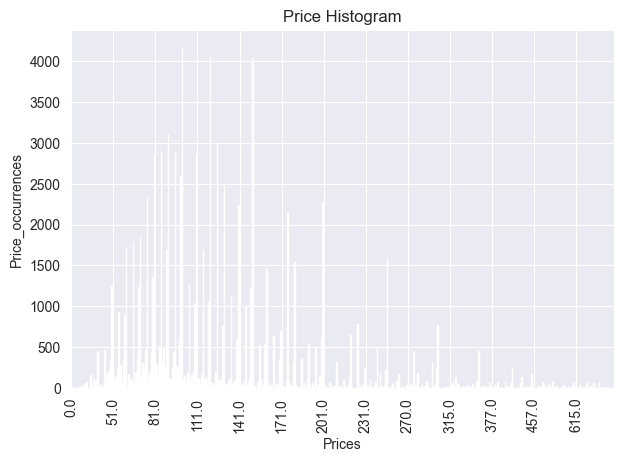

3


In [9]:
# Now we want to decide how to bin the prices in order to decide how to best bin them
import matplotlib.ticker as ticker

price_counts = df_avg_reviews['price'].value_counts()
price_counts = price_counts.sort_index()
price_counts.plot(kind='bar')
plt.title('Price Histogram')
plt.xlabel('Prices')
plt.ylabel('Price_occurrences')
plt.tight_layout()
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(nbins=15)) 
plt.show()
print(price_counts.iloc[0])

In [10]:
prices = df_avg_reviews['price'].unique()
prices.sort()
print(prices)

[   0.    8.   12.   19.   23.   24.   25.   26.   28.   29.   30.   32.
   33.   34.   35.   36.   37.   38.   39.   40.   41.   42.   43.   44.
   45.   46.   47.   48.   49.   50.   51.   52.   53.   54.   55.   56.
   57.   58.   59.   60.   61.   62.   63.   64.   65.   66.   67.   68.
   69.   70.   71.   72.   73.   74.   75.   76.   77.   78.   79.   80.
   81.   82.   83.   84.   85.   86.   87.   88.   89.   90.   91.   92.
   93.   94.   95.   96.   97.   98.   99.  100.  101.  102.  103.  104.
  105.  106.  107.  108.  109.  110.  111.  112.  113.  114.  115.  116.
  117.  118.  119.  120.  121.  122.  123.  124.  125.  126.  127.  128.
  129.  130.  131.  132.  133.  134.  135.  136.  137.  138.  139.  140.
  141.  142.  143.  144.  145.  146.  147.  148.  149.  150.  151.  152.
  153.  154.  155.  156.  157.  158.  159.  160.  161.  162.  163.  164.
  165.  166.  167.  168.  169.  170.  171.  172.  173.  174.  175.  176.
  177.  178.  179.  180.  181.  182.  183.  184.  1

From this plot we are able to extract the bins. We have decided to hand-pick the bins in order to put a more 'human' touch on the price range choice.
We also have discarded some absurdly high and absurdly low prices. This is done to remove the ifluence from misleading listings and listing-squatting

In [53]:
# now we create a function that returns the bin tag given the price
bin_tags_1 = ['EXTRA_CHEAP','CHEAP','AFFORDABLE','AVERAGE_PRICE','MID_HIGH','EXPENSIVE','EXTRA_EXPENSIVE','LUXURY']
bin_intervals_1 = [(0,35),(35,55),(55,100),(100,150),(150,200),(200,300),(300,450),(450,3000)]

bin_tags_2 = ['CHEAP','AFFORDABLE','MID','EXPENSIVE','LUXURY']

bin_intervals_2 = [(0,75),(75,200),(200,300),(300,3000)]
bin_intervals_3 = [(0,50),(50,70),(70,80),(80,90),(90,95),(95,100),(100,110),(120,130),(130,140),(150,160),(160,170),(170,180),(180,190),(200,300),(300,450),(450,3000)]

def price_to_bin_ID(price):
    for i, (start, end) in enumerate(bin_intervals_2):
        if start <= price < end:
            return i
    return -1

print(bin_tags_2[price_to_bin_ID(90)])


AFFORDABLE


In [54]:
# with the price bins defined now we proceed to start cutting the dataframe to prepare it for training

useful_columns_1 = ['id','rev_matrix','price']
df_cut = df_avg_reviews[useful_columns_1]
#print(df_cut.head(10))
print(df_cut.shape[0])
df_cut['price_bin'] = df_cut['price'].apply(price_to_bin_ID)
#df_cut['price_bin'] = pd.qcut(df_cut['price'], q = 5, labels= [0,1,2,3,4])
#df_cut['price_bin'] = df_cut.iloc[:,'price'] 
useful_columns_2 = ['id','rev_matrix','price_bin']
df_cut = df_cut[useful_columns_2]
df_cut = df_cut.loc[df_cut['price_bin']!=-1]

print(df_cut.head(10))
print(df_cut.shape[0])
elements_per_bin = df_cut['price_bin'].value_counts()
print(elements_per_bin)

102043
         id                                         rev_matrix  price_bin
0    846281  [[0.0, 0.0, 0.781112152437849, 0.9124018103622...          1
1   4248769  [[0.0, 0.8904492751602125, 0.8540025145138379,...          1
2   2206038  [[0.0, 0.0, 0.7080558820992712, 0.488841056583...          1
3    118117  [[0.8540614189967389, 0.0, 0.0, 0.0, 0.0, 0.90...          1
4   4892972  [[0.0, 0.0, 0.854067618073787, 0.0, 0.93747997...          1
5   2080040  [[0.5622811021301959, 0.0, 0.8748178878643644,...          1
6  15814593  [[0.5624849619387642, 0.0, 0.0, 0.0, 0.8540422...          1
7  12549908  [[0.6655248266079418, 0.5499686915595313, 0.82...          2
8     28658  [[0.0, 0.0, 0.7810900593662966, 0.0, 0.6274829...          0
9  25220875  [[0.5339686739183929, 0.0, 0.8540521750240769,...          2
102039
price_bin
1    72445
0    15743
2     9883
3     3968
Name: count, dtype: int64


C:\Users\flavi\AppData\Local\Temp\ipykernel_55100\4240101277.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cut['price_bin'] = df_cut['price'].apply(price_to_bin_ID)


The next operation is to explode the matrix in the rev_matrix field. The matrix gets flattened by multiplying each value of the first row by the corresponding one in the second row. This is just one strategy to take in to account the weigh of the topic in each review. I could also just use the topic probabilities or the overall sentiment of each topic alone.

In [55]:
def multiply_rev_matrix(rev_matrix):
    return np.multiply(rev_matrix[0],rev_matrix[1])

print('Multiplication test:', multiply_rev_matrix(np.array([[1,2,3,4],[1,2,3,4]])))

Multiplication test: [ 1  4  9 16]


In [56]:
def multiply_and_normalize(rev_matrix):
    return np.multiply(rev_matrix[0],(rev_matrix[1]+1))

In [57]:
def just_topic_scores(rev_matrix):
    return rev_matrix[0]

In [58]:
def just_sentiment(rev_matrix):
    return rev_matrix[1]

In [59]:
#print(df_cut.head(10))
print(df_cut['rev_matrix'].head(10))
#df_cut['rev_matrix'] = df_cut['rev_matrix'].apply(multiply_rev_matrix)
#df_cut['rev_matrix'] = df_cut['rev_matrix'].apply(just_sentiment)
#df_cut['rev_matrix'] = df_cut['rev_matrix'].apply(just_topic_scores)
df_cut['rev_matrix'] = df_cut['rev_matrix'].apply(multiply_and_normalize)
print(df_cut.head(10))

scores_df = pd.DataFrame(df_cut['rev_matrix'].tolist(),index=df_cut.index)
print(scores_df.head(10))

scores_df.columns = ['Ts_0','Ts_1','Ts_2','Ts_3','Ts_4','Ts_5','Ts_6','Ts_7']
df_cut = pd.concat([df_cut.drop(columns = ['rev_matrix']),scores_df], axis=1)
df_cut.to_csv(r'C:\Users\flavi\PycharmProjects\lda_test\processed_data\dataset_for_training_arbitrary_binning.csv')
zeros = (df_cut == 0.0).all(axis=1)
df_cut = df_cut[~zeros]
zeros = df_cut.eq(0.0).any(axis = 1)
#df_cut = df_cut[~zeros]
print(df_cut.head(10))

0    [[0.0, 0.0, 0.781112152437849, 0.9124018103622...
1    [[0.0, 0.8904492751602125, 0.8540025145138379,...
2    [[0.0, 0.0, 0.7080558820992712, 0.488841056583...
3    [[0.8540614189967389, 0.0, 0.0, 0.0, 0.0, 0.90...
4    [[0.0, 0.0, 0.854067618073787, 0.0, 0.93747997...
5    [[0.5622811021301959, 0.0, 0.8748178878643644,...
6    [[0.5624849619387642, 0.0, 0.0, 0.0, 0.8540422...
7    [[0.6655248266079418, 0.5499686915595313, 0.82...
8    [[0.0, 0.0, 0.7810900593662966, 0.0, 0.6274829...
9    [[0.5339686739183929, 0.0, 0.8540521750240769,...
Name: rev_matrix, dtype: object
         id                                         rev_matrix  price_bin
0    846281  [0.0, 0.0, 1.004471172427452, 1.25108536236873...          1
1   4248769  [0.0, 1.1450732453922752, 1.2720367453683616, ...          1
2   2206038  [0.0, 0.0, 0.9292879424611885, 0.6342468288643...          1
3    118117  [1.2444528936201484, 0.0, 0.0, 0.0, 0.0, 0.902...          1
4   4892972  [0.0, 0.0, 1.312872742503025, 0.0, 

In [60]:
print(df_cut.head(10))
print(df_cut.shape[0])

         id  price_bin      Ts_0      Ts_1      Ts_2      Ts_3      Ts_4  \
0    846281          1  0.000000  0.000000  1.004471  1.251085  0.000000   
1   4248769          1  0.000000  1.145073  1.272037  0.962174  0.000000   
2   2206038          1  0.000000  0.000000  0.929288  0.634247  0.993342   
3    118117          1  1.244453  0.000000  0.000000  0.000000  0.000000   
4   4892972          1  0.000000  0.000000  1.312873  0.000000  0.937480   
5   2080040          1  0.790848  0.000000  1.280208  0.000000  0.591273   
6  15814593          1  0.562485  0.000000  0.000000  0.000000  1.020837   
7  12549908          2  0.895397  0.708827  1.127047  0.680442  0.995514   
8     28658          0  0.000000  0.000000  0.887084  0.000000  0.857393   
9  25220875          2  0.728040  0.000000  1.131256  0.000000  0.824998   

       Ts_5      Ts_6      Ts_7  
0  0.000000  0.000000  0.480494  
1  0.000000  0.000000  0.000000  
2  0.000000  0.783876  0.000000  
3  0.902698  0.000000  0.00

Now we could try different techniques to fit the model I am splitting the dataset with a 80, 20 configuration

In [61]:
# Balancing the dataset 
from sklearn.utils import resample

min_class = df_cut['price_bin'].value_counts().min()

balanced_data = []

for cls in df_cut['price_bin'].unique():
    cls_subset = df_cut[df_cut['price_bin'] == cls]
    cls_downsampled = resample(cls_subset, replace= False, n_samples= min_class, random_state= 34)
    balanced_data.append(cls_downsampled)
    
df_cut=pd.concat(balanced_data)

In [62]:
Train_80 = df_cut.sample(frac = 0.8)
Xt_df = Train_80[['Ts_0','Ts_1','Ts_2','Ts_3','Ts_4','Ts_5','Ts_6','Ts_7']]
Xt = Xt_df.to_numpy()
Yt = Train_80['price_bin'].to_numpy()
print(Xt)
print(Yt)
Test_20 = df_cut.drop(Train_80.index)
Xtest = Test_20[['Ts_0','Ts_1','Ts_2','Ts_3','Ts_4','Ts_5','Ts_6','Ts_7']].to_numpy()
Ytest = Test_20['price_bin'].to_numpy()

[[0.         0.99829384 1.19820794 ... 0.60729133 0.         0.        ]
 [0.         0.         0.94124366 ... 0.         0.         0.        ]
 [0.         0.         1.08719545 ... 0.         0.         0.        ]
 ...
 [0.68026723 0.         0.99212516 ... 0.         0.         0.        ]
 [0.68026723 0.         0.89368635 ... 0.         0.58881101 0.92051803]
 [0.         0.         1.39930298 ... 1.24031598 0.         0.        ]]
[0 0 3 ... 1 3 2]


  Feature       VIF
0    Ts_0  1.341323
1    Ts_1  1.238543
2    Ts_2  1.785182
3    Ts_3  1.432795
4    Ts_4  1.641438
5    Ts_5  1.338737
6    Ts_6  1.409673
7    Ts_7  1.481722


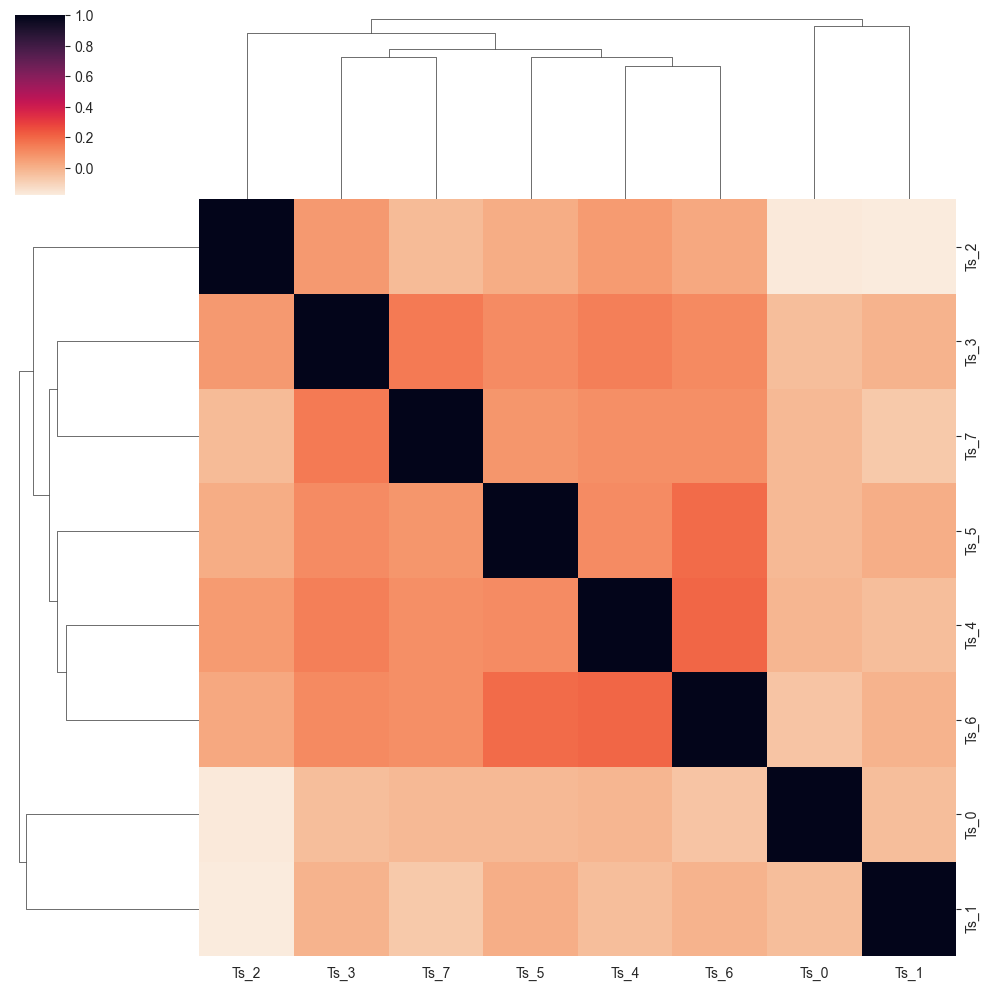

In [63]:
#investigating the correlation
from statsmodels.stats.outliers_influence import variance_inflation_factor
import seaborn as sns

sns_plot = sns.clustermap(Xt_df.corr(), cmap="rocket_r")
vif_data = pd.DataFrame()
vif_data["Feature"] = Xt_df.columns
vif_data["VIF"] = [variance_inflation_factor(Xt_df.values, i) for i in range(len(Xt_df.columns))]

print(vif_data)

Let's try with randoom forest! 

In [73]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MaxAbsScaler

scaler = StandardScaler()
Xt = scaler.fit_transform(Xt)
print(Xt)
Xtest = scaler.fit_transform(Xtest)
print(Xtest)

print('Number of training samples: ',Xt.shape[0])

rf_classifier = RandomForestClassifier(n_estimators=10,random_state=42, n_jobs=-1)
rf_classifier.fit(Xt,Yt)


[[-0.79710912  1.59687514  0.98116145 ...  1.21605097 -0.56314187
  -0.73456391]
 [-0.79710912 -0.65231707  0.47786581 ... -0.5428084  -0.56314187
  -0.73456391]
 [-0.79710912 -0.65231707  0.76373005 ... -0.5428084  -0.56314187
  -0.73456391]
 ...
 [ 0.62136626 -0.65231707  0.57752337 ... -0.5428084  -0.56314187
  -0.73456391]
 [ 0.62136626 -0.65231707  0.38471906 ... -0.5428084   0.92039341
   1.19647983]
 [-0.79710912 -0.65231707  1.37503045 ...  3.04944012 -0.56314187
  -0.73456391]]
[[-0.79985339 -0.65660425  0.81813972 ... -0.50856436 -0.54498351
   1.78692051]
 [ 1.59492097 -0.65660425  1.26356717 ... -0.50856436 -0.54498351
  -0.74143176]
 [-0.79985339 -0.65660425  0.98339574 ... -0.50856436 -0.54498351
  -0.74143176]
 ...
 [ 1.68345145 -0.65660425  0.22590581 ... -0.50856436 -0.54498351
  -0.74143176]
 [ 0.2494115  -0.65660425 -1.37957976 ...  1.94502326  1.6054833
  -0.74143176]
 [-0.79985339 -0.65660425 -1.37957976 ...  1.8354053  -0.54498351
  -0.74143176]]
Number of trainin

RandomForestClassifier(n_estimators=10, n_jobs=-1, random_state=42)

In [74]:
y_pred = rf_classifier.predict(Xt)
accuracy = accuracy_score(Yt, y_pred)
print(f'Train accuracy: {accuracy}')

Train accuracy: 0.9684202236572689


Test accuracy: 0.2942659105229994
[[332 200 127 132]
 [237 193 182 165]
 [200 197 192 204]
 [177 209 210 217]]


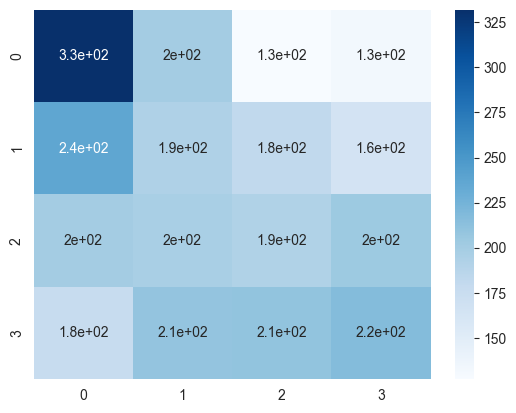

In [75]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns 

y_pred_test = rf_classifier.predict(Xtest)
test_accuracy = accuracy_score(Ytest, y_pred_test)
conf_matrix = confusion_matrix(Ytest,y_pred_test)
print(f'Test accuracy: {test_accuracy}')
print(conf_matrix)
vis_cf = sns.heatmap(conf_matrix, annot= True, cmap='Blues')


In [ ]:
from sklearn.decomposition import PCA

pca = PCA

In [67]:
import graphviz
from sklearn.tree import export_graphviz

tree = rf_classifier.estimators_[0]

dot_data = export_graphviz(tree, out_file=None,filled=True,rounded=True, special_characters=True) 

graph = graphviz.Source(dot_data)  
graph.render("iris_tree")  # Save the tree as a file
graph.view()


ExecutableNotFound: failed to execute WindowsPath('dot'), make sure the Graphviz executables are on your systems' PATH

Let's try QDA

Train accuracy: 0.34737753977004254
[[1649  551  235  742]
 [1022  793  364 1012]
 [ 796  648  439 1292]
 [ 702  544  379 1530]]
Test accuracy: 0.3440453686200378


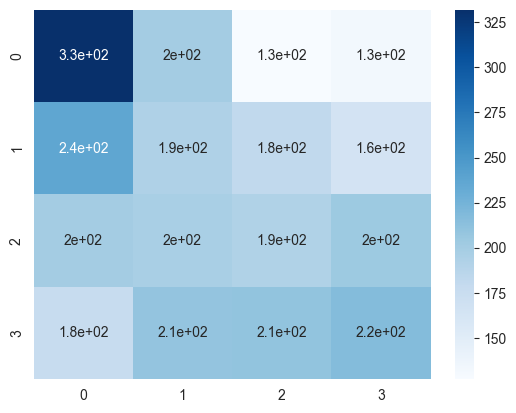

In [77]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, classification_report

qda = QuadraticDiscriminantAnalysis()

qda.fit(Xt,Yt)
y_qda_predict = qda.predict(Xt)
qda_train_accuracy = accuracy_score(Yt,y_qda_predict)
y_pred_qda_test = qda.predict(Xtest)
qda_test_accuracy = accuracy_score(Ytest,y_pred_qda_test)
print(f'Train accuracy: {qda_train_accuracy}')
print(confusion_matrix(Yt,y_qda_predict))
print(f'Test accuracy: {qda_test_accuracy}')
test_conf_matrix = confusion_matrix(Ytest,y_pred_qda_test)
vis_cf_QDA = sns.heatmap(conf_matrix, annot= True, cmap='Blues')


Maybe svm with a radial kernel

In [69]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


scaler =MaxAbsScaler()
Xt_scaled = scaler.fit_transform(Xt)
Xtest_scaled = scaler.fit_transform(Xtest)

svm = SVC(kernel='rbf',C=1.0, gamma='scale',degree=5)
svm.fit(Xt,Yt)
Y_svm_pred = svm.predict(Xt)
print(f'Train accuracy:', accuracy_score(Yt,Y_svm_pred))
conf_matrix_svm = confusion_matrix(Yt,Y_svm_pred)
print(conf_matrix_svm)
Y_svm_pred_test = svm.predict(Xtest)
conf_matrix_svm = confusion_matrix(Ytest,Y_svm_pred_test)
print('Test accuracy:', accuracy_score(Ytest,Y_svm_pred_test))
print(conf_matrix_svm)


Train accuracy: 0.36793195778862814
[[1632  728  201  616]
 [ 915 1075  319  882]
 [ 701  834  528 1112]
 [ 655  708  355 1437]]
Test accuracy: 0.3367989918084436
[[390 193  67 141]
 [243 235  81 218]
 [173 201 105 314]
 [155 204 115 339]]
